In [30]:
# One-liner: Import libraries, set options, and lock a random seed for reproducibility.
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
np.random.seed(42)
plt.rcParams["figure.figsize"] = (8,5)


In [16]:
# One-liner: Load the Wine dataset (178 samples, 13 features, 3 classes) and preview shapes.
wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = pd.Series(wine.target, name="target")
X.shape, y.value_counts().sort_index()


((178, 13),
 target
 0    59
 1    71
 2    48
 Name: count, dtype: int64)

In [17]:
# One-liner: Split data into 70% train, 20% validation, 10% test with stratification.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, stratify=y_temp, random_state=42)

len(X_train), len(X_val), len(X_test)


(124, 36, 18)

In [18]:
# One-liner: Define helpers to compute metrics and to format results as a comparison table row.
def eval_metrics(y_true, y_pred, average="macro"):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average=average, zero_division=0),
        "recall": recall_score(y_true, y_pred, average=average, zero_division=0),
        "f1": f1_score(y_true, y_pred, average=average, zero_division=0),
    }

def add_result(results, label, y_true, y_pred):
    m = eval_metrics(y_true, y_pred)
    results.append({"model": label, **m})


In [19]:
# One-liner: Train baseline trees (gini and entropy) and evaluate on validation and test sets.
results = []

# Baseline CART (gini)
cart = DecisionTreeClassifier(criterion="gini", random_state=42)
cart.fit(X_train, y_train)
add_result(results, "CART (gini) – VAL", y_val, cart.predict(X_val))
add_result(results, "CART (gini) – TEST", y_test, cart.predict(X_test))

# “ID3-like” (entropy) — still binary splits in sklearn
id3_like = DecisionTreeClassifier(criterion="entropy", random_state=42)
id3_like.fit(X_train, y_train)
add_result(results, "ID3-like (entropy) – VAL", y_val, id3_like.predict(X_val))
add_result(results, "ID3-like (entropy) – TEST", y_test, id3_like.predict(X_test))

pd.DataFrame(results)


,model,accuracy,precision,recall,f1
0,CART (gini) – VAL,0.944444,0.958333,0.938889,0.945741
1,CART (gini) – TEST,1.000000,1.000000,1.000000,1.000000
2,ID3-like (entropy) – VAL,0.888889,0.888889,0.900794,0.890637
3,ID3-like (entropy) – TEST,0.944444,0.958333,0.944444,0.947475


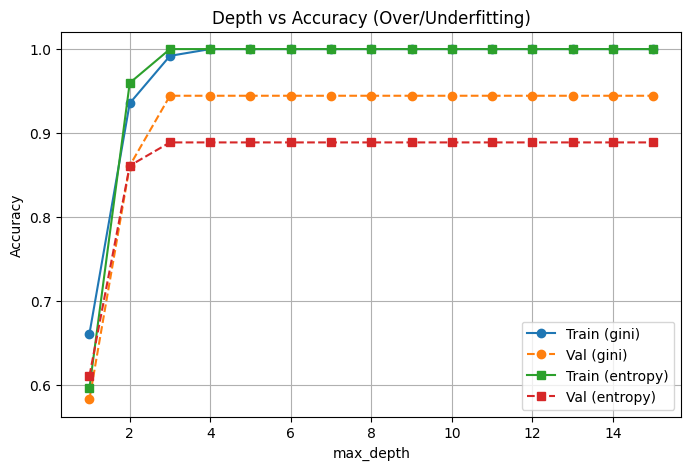

(3, 3)

In [20]:
# One-liner: Sweep max_depth to visualize train vs validation accuracy (over/underfitting behavior).
depths = range(1, 16)
train_acc_gini, val_acc_gini = [], []
train_acc_entropy, val_acc_entropy = [], []

for d in depths:
    g = DecisionTreeClassifier(criterion="gini", max_depth=d, random_state=42).fit(X_train, y_train)
    e = DecisionTreeClassifier(criterion="entropy", max_depth=d, random_state=42).fit(X_train, y_train)
    train_acc_gini.append(accuracy_score(y_train, g.predict(X_train)))
    val_acc_gini.append(accuracy_score(y_val, g.predict(X_val)))
    train_acc_entropy.append(accuracy_score(y_train, e.predict(X_train)))
    val_acc_entropy.append(accuracy_score(y_val, e.predict(X_val)))

plt.plot(depths, train_acc_gini, marker="o", label="Train (gini)")
plt.plot(depths, val_acc_gini, marker="o", linestyle="--", label="Val (gini)")
plt.plot(depths, train_acc_entropy, marker="s", label="Train (entropy)")
plt.plot(depths, val_acc_entropy, marker="s", linestyle="--", label="Val (entropy)")
plt.xlabel("max_depth"); plt.ylabel("Accuracy"); plt.title("Depth vs Accuracy (Over/Underfitting)")
plt.legend(); plt.grid(True); plt.show()

# Pick depth at/near peak val accuracy (example: best for gini and entropy)
best_depth_gini = depths[int(np.argmax(val_acc_gini))]
best_depth_entropy = depths[int(np.argmax(val_acc_entropy))]
best_depth_gini, best_depth_entropy


In [21]:
# One-liner: Constrain tree to roughly half of the features (max_features=6) to reduce complexity.
half_feats = 6  # ~ half of 13
g_half = DecisionTreeClassifier(criterion="gini", max_features=half_feats, random_state=42).fit(X_train, y_train)
e_half = DecisionTreeClassifier(criterion="entropy", max_features=half_feats, random_state=42).fit(X_train, y_train)

add_result(results, f"CART (gini, max_features={half_feats}) – VAL", y_val, g_half.predict(X_val))
add_result(results, f"ID3-like (entropy, max_features={half_feats}) – VAL", y_val, e_half.predict(X_val))
pd.DataFrame(results)


,model,accuracy,precision,recall,f1
0,CART (gini) – VAL,0.944444,0.958333,0.938889,0.945741
1,CART (gini) – TEST,1.000000,1.000000,1.000000,1.000000
2,ID3-like (entropy) – VAL,0.888889,0.888889,0.900794,0.890637
3,ID3-like (entropy) – TEST,0.944444,0.958333,0.944444,0.947475
4,"CART (gini, max_features=6) – VAL",0.944444,0.945887,0.948413,0.945825
5,"ID3-like (entropy, max_features=6) – VAL",0.861111,0.879902,0.848413,0.857670


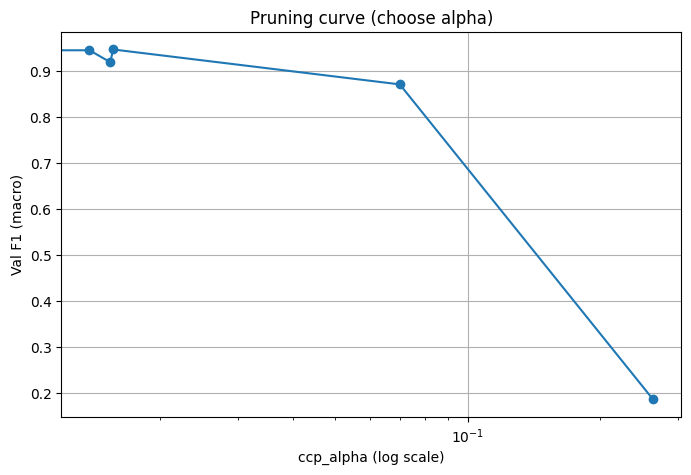

np.float64(0.015654648956356734)

In [22]:
# One-liner: Use cost-complexity pruning path to pick ccp_alpha that maximizes validation F1.
alphas, val_f1s = [], []
path = DecisionTreeClassifier(random_state=42).cost_complexity_pruning_path(X_train, y_train)

for a in path.ccp_alphas:
    clf = DecisionTreeClassifier(criterion="gini", ccp_alpha=a, random_state=42).fit(X_train, y_train)
    val_f1s.append(f1_score(y_val, clf.predict(X_val), average="macro", zero_division=0))
    alphas.append(a)

best_alpha = alphas[int(np.argmax(val_f1s))]
plt.plot(alphas, val_f1s, marker="o"); plt.xscale("log")
plt.xlabel("ccp_alpha (log scale)"); plt.ylabel("Val F1 (macro)"); plt.title("Pruning curve (choose alpha)")
plt.grid(True); plt.show()

best_alpha


In [23]:
# One-liner: Fit chosen models on TRAIN+VAL and evaluate once on TEST (hold-out).
# Merge train+val for final training
X_train_final = pd.concat([X_train, X_val], axis=0)
y_train_final = pd.concat([y_train, y_val], axis=0)

final_results = []

# Best-depth gini
final_gini = DecisionTreeClassifier(criterion="gini", max_depth=best_depth_gini, random_state=42).fit(X_train_final, y_train_final)
yp = final_gini.predict(X_test)
add_result(final_results, f"Final CART (gini, depth={best_depth_gini}) – TEST", y_test, yp)

# Best-depth entropy
final_ent = DecisionTreeClassifier(criterion="entropy", max_depth=best_depth_entropy, random_state=42).fit(X_train_final, y_train_final)
yp = final_ent.predict(X_test)
add_result(final_results, f"Final ID3-like (entropy, depth={best_depth_entropy}) – TEST", y_test, yp)

# Best alpha (pruned, gini)
final_pruned = DecisionTreeClassifier(criterion="gini", ccp_alpha=best_alpha, random_state=42).fit(X_train_final, y_train_final)
yp = final_pruned.predict(X_test)
add_result(final_results, f"Final CART (gini, pruned α={best_alpha:.2e}) – TEST", y_test, yp)

pd.DataFrame(final_results)


,model,accuracy,precision,recall,f1
0,"Final CART (gini, depth=3) – TEST",1.000000,1.000000,1.000000,1.000000
1,"Final ID3-like (entropy, depth=3) – TEST",1.000000,1.000000,1.000000,1.000000
2,"Final CART (gini, pruned α=1.57e-02) – TEST",0.888889,0.885714,0.885714,0.885714


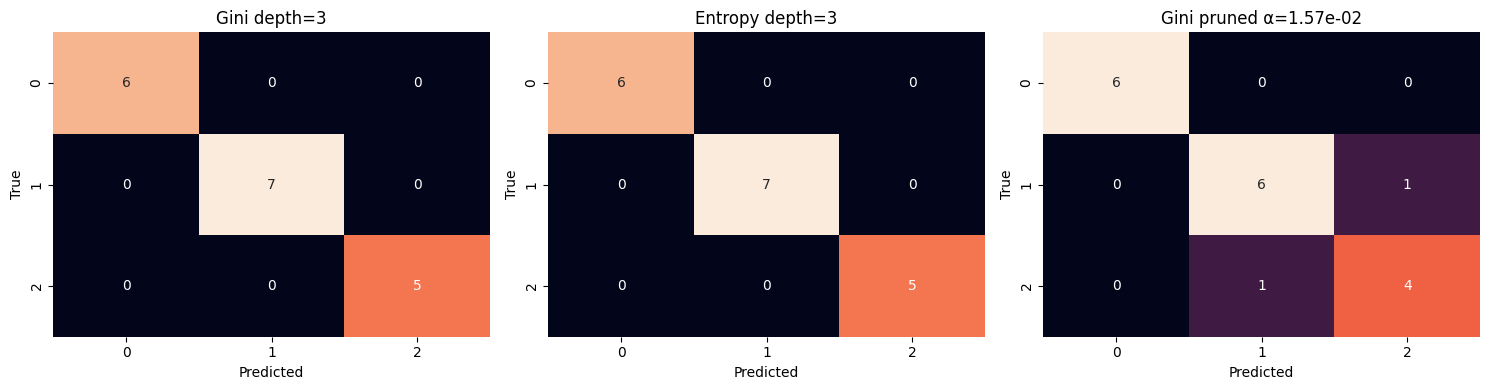

In [24]:
# One-liner: Visualize confusion matrices on TEST for the three final models.
models = {
    f"Gini depth={best_depth_gini}": final_gini,
    f"Entropy depth={best_depth_entropy}": final_ent,
    f"Gini pruned α={best_alpha:.2e}": final_pruned
}

fig, axes = plt.subplots(1, 3, figsize=(15,4))
for ax, (name, model) in zip(axes, models.items()):
    cm = confusion_matrix(y_test, model.predict(X_test))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False, ax=ax)
    ax.set_title(name); ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.tight_layout(); plt.show()


In [25]:
# One-liner: Aggregate and display a single comparative table across settings.
comp = pd.concat([
    pd.DataFrame(results),
    pd.DataFrame(final_results)
], ignore_index=True)

comp = comp[["model","accuracy","precision","recall","f1"]].sort_values(by=["model"]).reset_index(drop=True)
comp


,model,accuracy,precision,recall,f1
0,CART (gini) – TEST,1.000000,1.000000,1.000000,1.000000
1,CART (gini) – VAL,0.944444,0.958333,0.938889,0.945741
2,"CART (gini, max_features=6) – VAL",0.944444,0.945887,0.948413,0.945825
3,"Final CART (gini, depth=3) – TEST",1.000000,1.000000,1.000000,1.000000
4,"Final CART (gini, pruned α=1.57e-02) – TEST",0.888889,0.885714,0.885714,0.885714
5,"Final ID3-like (entropy, depth=3) – TEST",1.000000,1.000000,1.000000,1.000000
6,ID3-like (entropy) – TEST,0.944444,0.958333,0.944444,0.947475
7,ID3-like (entropy) – VAL,0.888889,0.888889,0.900794,0.890637
8,"ID3-like (entropy, max_features=6) – VAL",0.861111,0.879902,0.848413,0.857670


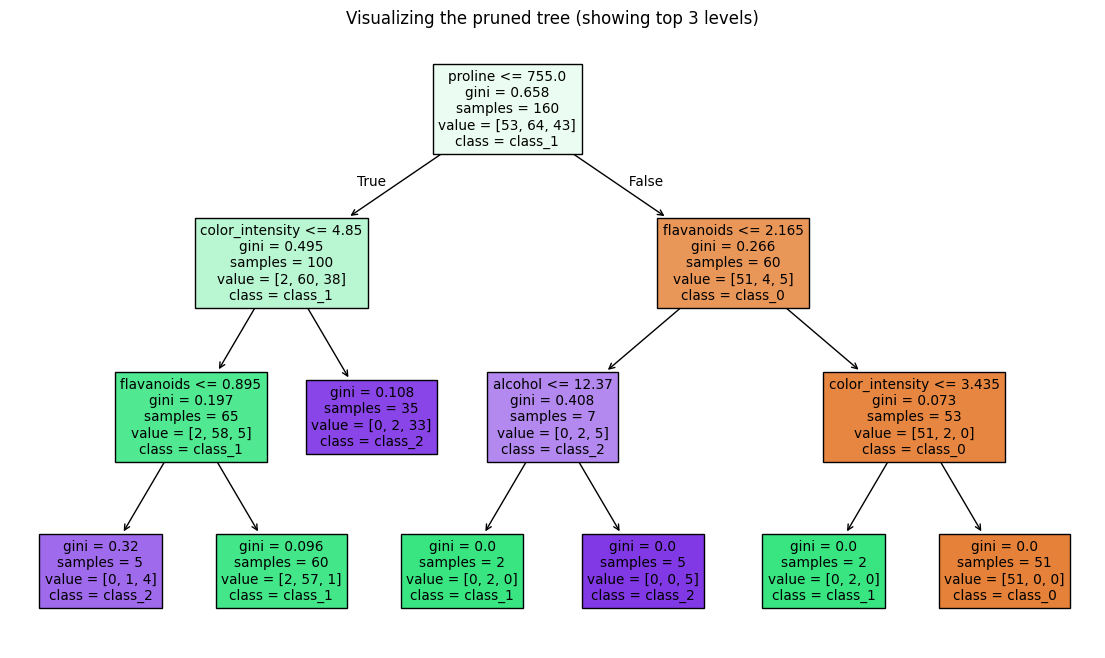

In [34]:
# One-liner: Plot the pruned tree (or a depth-limited tree) to inspect complexity.
plt.figure(figsize=(14,8))
plot_tree(final_pruned, feature_names=wine.feature_names, class_names=wine.target_names, filled=True, max_depth=3)
plt.title("Visualizing the pruned tree (showing top 3 levels)")
plt.show()
